In [1]:
# !pip install lifelines --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import plotly.graph_objects as go
import os
import re
import datetime as dt
pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings('ignore')

# import lifelines

In [ ]:
https://medium.com/@chenchungwai/using-monte-carlo-simulation-parameter-optimization-and-sensitivity-analysis-to-optimize-process-1f6d1f86e54

In [ ]:
https://towardsdatascience.com/bayesian-customer-lifetime-values-modeling-using-pymc3-d770676f5c06

In [ ]:
https://www.kaggle.com/code/adamwurdits/causal-inference-with-dowhy-a-practical-guide

# Causal Inference

In [ ]:
https://www.depends-on-the-definition.com/causal-graphs-and-deconfounding/

In [ ]:
https://saturncloud.io/blog/solving-the-modulenotfounderror-no-module-named-pygraphviz-in-anaconda3/

In [3]:
import dowhy
from dowhy import CausalModel

In [4]:
np.random.seed(42)

num_users = 10000
num_months = 12

signup_months = np.random.choice(np.arange(1, num_months), num_users) * np.random.randint(0,2, size=num_users) # signup_months == 0 means customer did not sign up
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months),
    'signup_month': np.repeat(signup_months, num_months), # signup month == 0 means customer did not sign up
    'month': np.tile(np.arange(1, num_months+1), num_users), # months are from 1 to 12
    'spend': np.random.poisson(500, num_users*num_months) #np.random.beta(a=2, b=5, size=num_users * num_months)*1000 # centered at 500
})
# A customer is in the treatment group if and only if they signed up
df["treatment"] = df["signup_month"]>0
# Simulating an effect of month (monotonically decreasing--customers buy less later in the year)
df["spend"] = df["spend"] - df["month"]*10
# Simulating a simple treatment effect of 100
after_signup = (df["signup_month"] < df["month"]) & (df["treatment"])
df.loc[after_signup,"spend"] = df[after_signup]["spend"] + 100

In [11]:
i = 3

causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z->treatment;
pre_spends -> treatment;
treatment->post_spends;
signup_month->post_spends;
signup_month->treatment;
}"""

In [12]:
df_i_signupmonth = (
    df[df.signup_month.isin([0, i])]
    .groupby(["user_id", "signup_month", "treatment"],as_index=False)
    .apply(
        lambda x: pd.Series(
            {
                "pre_spends": x.loc[x.month < i, "spend"].mean(),
                "post_spends": x.loc[x.month > i, "spend"].mean(),
            }
        )
    )
)

In [14]:
model=dowhy.CausalModel(data=df_i_signupmonth,
                 graph=causal_graph.replace('\n',' '),
                  treatment='treatment',
                  outcome='post_spends'
                 
                 )

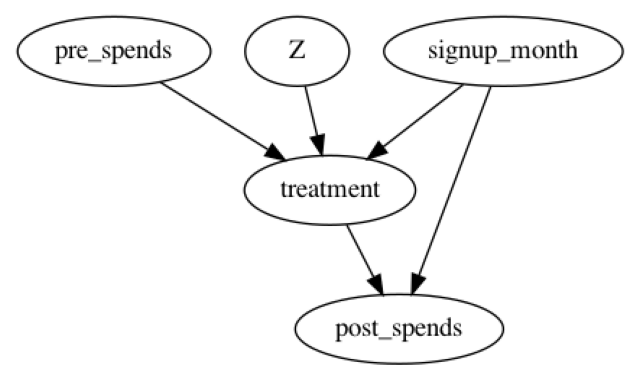

In [15]:
model.view_model()

In [18]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                             -1⎤
 ⎢       d                      ⎛       d                     ⎞  ⎥
E⎢────────────────(post_spends)⋅⎜────────────────([treatment])⎟  ⎥
 ⎣d[Z  pre_spends]              ⎝d[Z  pre_spends]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→post_spends then ¬(U →→{Z,pre_spends})
Estimand assumption 2, Exclusion: If we remove {Z,pre_spends}→{treatment}, then ¬({Z,pre_spends}→post_spends)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [19]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name='backdoor.propensity_score_matching',
                                 target_units='att')
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

## Realized estimand
b: post_spends~treatment+signup_month
Target units: att

## Estimate
Mean value: 97.49138947865055



In [23]:
# Textual Interpreter
interpretation = estimate.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [treatment] from 0 to 1 causes an increase of 97.49138947865055 in the expected value of the outcome [['post_spends']], over the data distribution/population represented by the dataset.


In [20]:
refutation = model.refute_estimate(identified_estimand, estimate, method_name='placebo_treatment_refuter',
                     placebo_type='permute', num_simulations=20)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:97.49138947865055
New effect:-2.3530903514979893
p value:0.14162857711841736



In [29]:
refutel = model.refute_estimate(identified_estimand,estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:97.49138947865055
New effect:99.73147182004999
p value:0.78



In [2]:
df=pd.read_csv(
    'https://raw.githubusercontent.com/treselle-systems/'
    'customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df['tenure']=df.tenure.astype(float)

df['Churn']=df.Churn=='Yes'

df.rename(columns=lambda x:x.lower(),inplace=True)

Text(0, 0.5, 'Customer Survival Chance (%)')

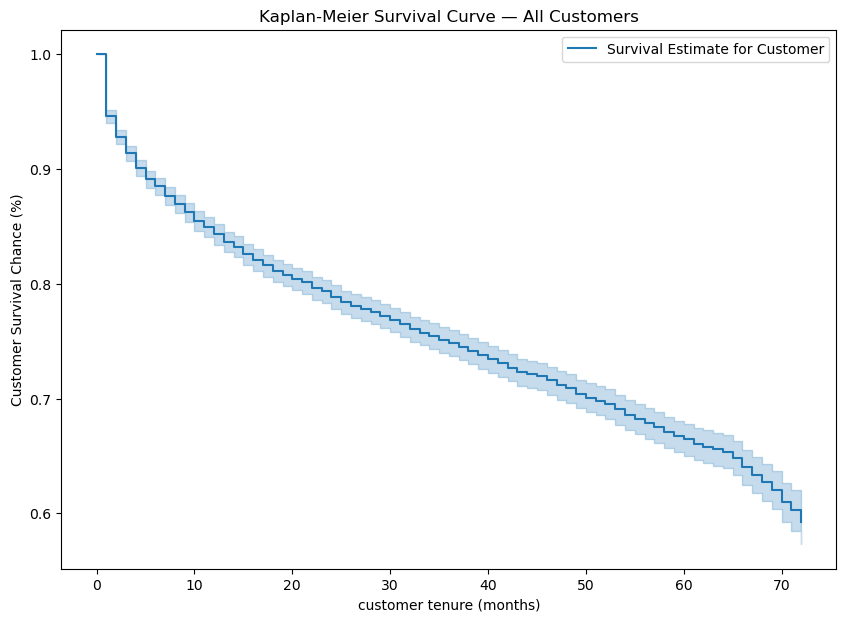

In [27]:
t=df.tenure.values
churn=df.churn.values
kmf=lifelines.KaplanMeierFitter()
kmf.fit(t,event_observed=churn,label='Survival Estimate for Customer')

fig,ax=plt.subplots(figsize=(10,7))
g=kmf.plot(ax=ax)
g.set_title('Kaplan-Meier Survival Curve — All Customers')
g.set_xlabel('customer tenure (months)')
g.set_ylabel('Customer Survival Chance (%)')

In [40]:
features_to_drop = ['customerid', 'gender', 'phoneservice', 'internetservice']
# engineering numeric columns for Cox Proportional Hazard estimation
churn_hazard = df.drop(features_to_drop, axis=1).copy()

# convert some stuff to integers
churn_hazard['totalcharges'] = pd.to_numeric(churn_hazard['totalcharges'], errors='coerce')
churn_hazard['totalcharges'].fillna(0, inplace=True)

# a lot of variables are encoded as 'Yes' or 'No', lets get these all done at once
binary_features = ['partner', 'dependents', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 
                   'streamingtv','streamingmovies', 'paperlessbilling']
for feat in binary_features:
    churn_hazard[feat] = churn_hazard[feat] == 'Yes'
    
# let's one hot encode the remaining categorical features
ohe_features = ['multiplelines', 'contract', 'paymentmethod']
churn_hazard = pd.get_dummies(churn_hazard, 
                              drop_first=True,
                              columns=ohe_features)

In [41]:
cph=lifelines.CoxPHFitter()
cph.fit(churn_hazard,duration_col='tenure',event_col='churn',show_progress=False)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12688.70
         time fit was run = 2023-10-11 08:48:08 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
seniorcitizen                           0.03       1.03       0.06            -0.08             0.14                 0.93                 1.16
partner                                -0.19       0.82       0.06            -0.30            -0.09                 0.74                 0.92
dependents                             -0.10       0.91       0.07            -0.23             0.04                 0.79                 1.04
onlinesecurity                         -0.38       0.68       0.07            -0.51            -0.25                 0.60                 0.78
onlinebackup                           -0.29       0.75       0.06            -0.40            -0.18                 0.67                 0.83
deviceprotection                       -0.16       0.85       0.06            -0.27            -0.05                 0.76                 0.95
techsupport                            -0.28       0.76       0.07            -0.41            -0.15                 0.67                 0.86
streamingtv                            -0.27       0.77       0.06            -0.38            -0.15                 0.68                 0.86
streamingmovies                        -0.26       0.77       0.06            -0.38            -0.14                 0.69                 0.87
paperlessbilling                        0.16       1.17       0.06             0.05             0.27                 1.05                 1.31
monthlycharges                          0.07       1.07       0.00             0.06             0.07                 1.06                 1.07
totalcharges                           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
multiplelines_No phone service          0.64       1.89       0.12             0.41             0.87                 1.51                 2.38
multiplelines_Yes                      -0.20       0.82       0.05            -0.30            -0.09                 0.74                 0.91
contract_One year                      -1.40       0.25       0.10            -1.60            -1.20                 0.20                 0.30
contract_Two year                      -4.05       0.02       0.20            -4.43            -3.66                 0.01                 0.03
paymentmethod_Credit card (automatic)  -0.01       0.99       0.09            -0.18             0.17                 0.83                 1.19
paymentmethod_Electronic check          0.38       1.46       0.07             0.24             0.52                 1.27                 1.69
paymentmethod_Mailed check              0.52       1.68       0.09             0.35             0.69                 1.42                 1.99

                                        cmp to      z      p   -log2(p)
covariate                                                              
seniorcitizen                             0.00   0.60   0.55       0.87
partner                                   0.00  -3.52 <0.005      11.20
dependents                                0.00  -1.39   0.17       2.60
onlinesecurity                            0.00  -5.65 <0.005      25.89
onlinebackup                              0.00  -5.22 <0.005      22.41
deviceprotection                          0.00  -2.85 <0.005       7.85
techsupport                               0.00  -4.19 <

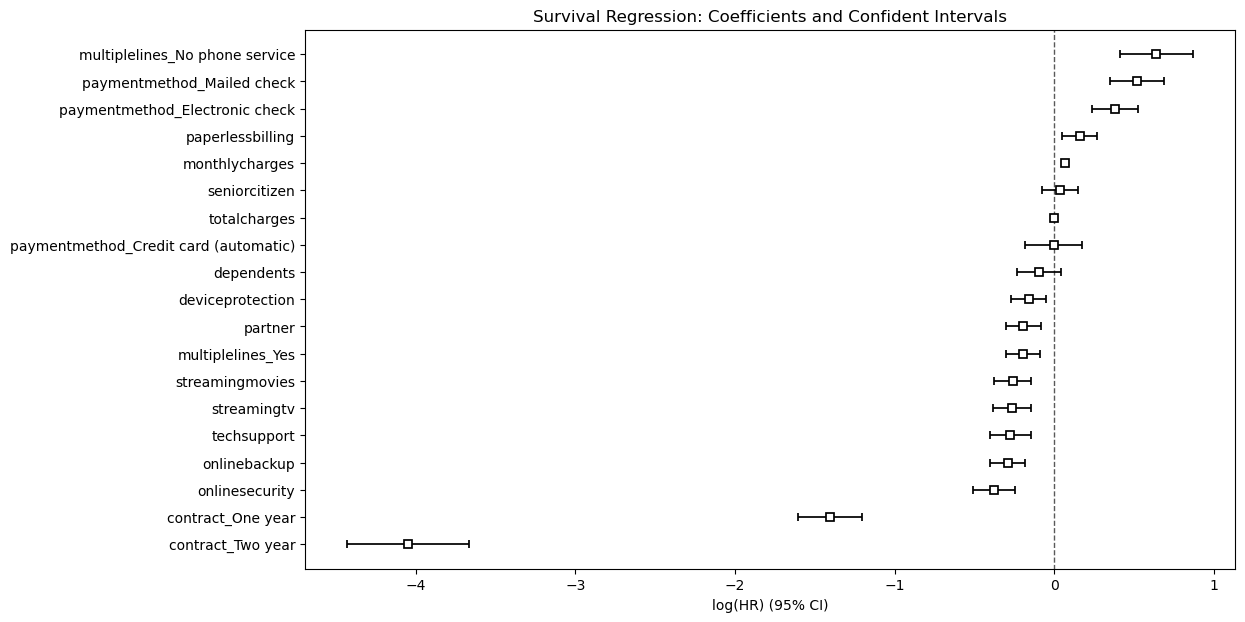

In [42]:
fig_coef, ax_coef = plt.subplots(figsize=(12,7))
ax_coef.set_title('Survival Regression: Coefficients and Confident Intervals')
cph.plot(ax=ax_coef);

In [49]:
def plot_categorical_survival(feature, t='tenure', event='churn', df=df, ax=None):
    for cat in df[feature].unique():
        idx = df[feature] == cat
        kmf = lifelines.KaplanMeierFitter()
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        kmf.plot(ax=ax, label=cat)

Text(0, 0.5, 'Customer Survival Chance (%)')

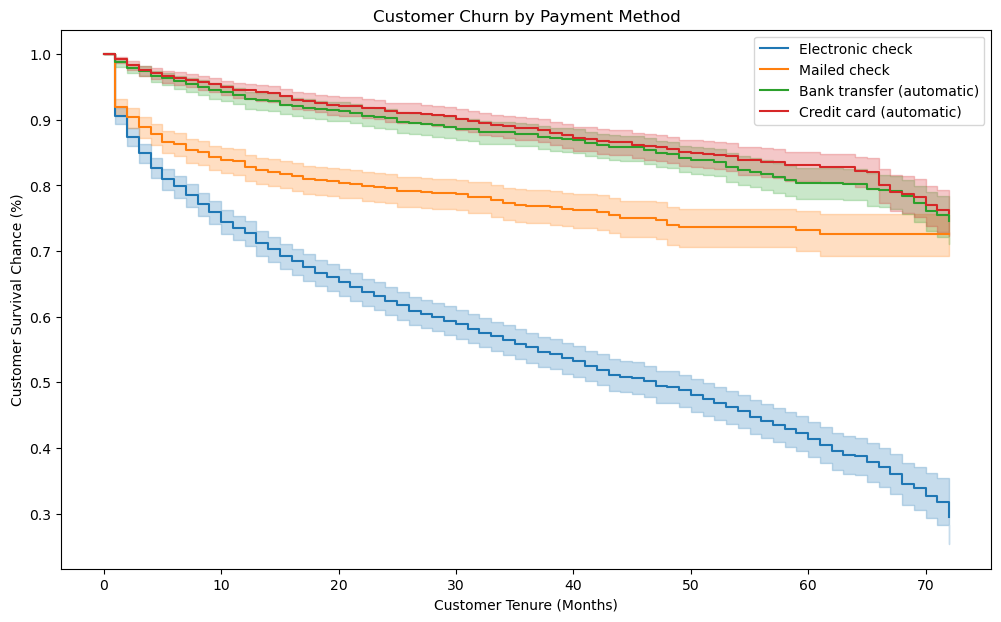

In [51]:
fig_pmt, ax_pmt = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='paymentmethod', ax=ax_pmt)
ax_pmt.set_title('Customer Churn by Payment Method')
ax_pmt.set_xlabel('Customer Tenure (Months)')
ax_pmt.set_ylabel('Customer Survival Chance (%)')


## Monte Carlo Simulation 

In [3]:
import statsmodels.api as sm

In [67]:
temp=pd.DataFrame(np.linspace(90,100,100)).rename(columns={0:'Y'})

x1=np.random.randint(1,20,100)
x2=np.random.randint(25,60,100)
x3=np.random.randint(6,20,100)
x4=np.random.randint(33,70,100)

x1=pd.DataFrame(x1).rename(columns={0:'X1'})
x2=pd.DataFrame(x2).rename(columns={0:'X2'})
x3=pd.DataFrame(x3).rename(columns={0:'X3'})
x4=pd.DataFrame(x4).rename(columns={0:'X4'})

df=pd.concat([temp,x1,x2,x3,x4],axis=1)

y=df.Y

X=df.drop('Y',axis=1)

X=sm.add_constant(X)

model=sm.OLS(y,X).fit()

In [ ]:
# selected_features=model.pvalues.idxmax()

# while model.pvalues.max()>0.09:
#     X=X.drop(selected_features,axis=1)
#     model=sm.OLS(y,X).fit()
#     selected_features=model.pvalues.idxmax()

In [68]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif=pd.DataFrame()

vif['predictors']=X.columns

vif['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]

In [88]:
coeffs=model.params

regression_equation=f'Y={coeffs.const:.2f}'

for p in coeffs.index[1:]:
    regression_equation+=f'+{coeffs[p]:.2f} *{p}'

In [106]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.5477
Date:                Thu, 12 Oct 2023   Prob (F-statistic):              0.701
Time:                        11:19:02   Log-Likelihood:                -247.77
No. Observations:                 100   AIC:                             505.5
Df Residuals:                      95   BIC:                             518.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         96.7502      2.128     45.474      0.000      92.526     100.974
X1            -0.0757      0.056     -1.352      0.180      -0.187       0.035
X2             0.0039      0.031      0.128      0.898      -0.057       0.065
X3            -0.0134      0.072     -0.185      0.853      -0.157       0.130
X4            -0.0176      0.027     -0.642      0.523      -0.072       0.037
==============================================================================
Omnibus:                       39.947   Durbin-Watson:                   0.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.457
Skew:                           0.073   Prob(JB):                       0.0396
Kurtosis:                       1.764   Cond. No.                         491.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
# Define the regression equation coefficients
intercept = 52.58
coef_x1 = 1.468
coef_x2 = 0.6623

# Define the target value, lower spec, and upper spec for y
target_y = 95.4
lower_spec = 91.6
upper_spec = 99.2

# Define the mean and standard deviation for X1 and X2
mean_x1 = 7.5
std_x1 = 0.6
mean_x2 = 48
std_x2 = 1.3

# Set the number of iterations for the Monte Carlo simulation
num_iterations = 1000000

# Initialize array to store the simulated y values
simulated_y = np.zeros(num_iterations)

# Perform the Monte Carlo simulation
for i in range(num_iterations):
    # Generate random samples for X1 and X2
    x1 = np.random.normal(mean_x1, std_x1)
    x2 = np.random.normal(mean_x2, std_x2)

    # Calculate the predicted value of y using the regression equation
    y_predicted = intercept + coef_x1 * x1 + coef_x2 * x2

    # Store the predicted value of y
    simulated_y[i] = y_predicted

# Calculate the mean and standard deviation of the simulated y values
mean_simulated_y = np.mean(simulated_y)
std_simulated_y = np.std(simulated_y)

# Calculate the count and percentage of out-of-specification values
out_of_spec_count = np.sum((simulated_y < lower_spec) | (simulated_y > upper_spec))
out_of_spec_percentage = out_of_spec_count / num_iterations * 100

# Calculate the process capability (Cp)
cp = (upper_spec - lower_spec) / (6 * np.std(simulated_y))

# Calculate the process centering (Cpk)
cpk = min((upper_spec - mean_simulated_y) / (3 * np.std(simulated_y)),
           (mean_simulated_y - lower_spec) / (3 * np.std(simulated_y)))

# Calculate the Process Performance Index (Ppk)
ppk = min(cp, cpk)

In [5]:
file=[d for d in os.listdir(os.getcwd()) if d.endswith('xlsx')][0]

df=pd.read_excel(os.path.join(os.getcwd()+f'/{file}'),nrows=10000,dtype={'CustomerID':str,})

df.rename(columns=lambda x:re.sub('\W+','',x).lower().strip(''),inplace=True)

df['invoicedate']=pd.to_datetime(df.invoicedate)


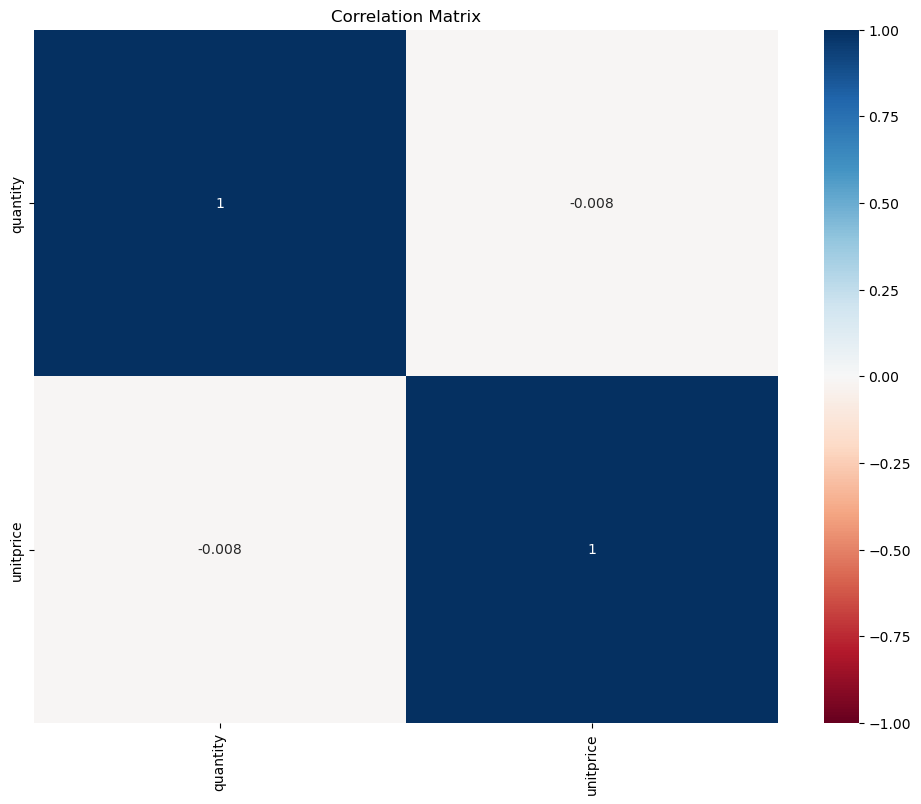

In [6]:
plt.figure(figsize=(12, 9))
s = sns.heatmap(df.corr(),
                annot=True,
                cmap='RdBu',
                vmin=-1,
                vmax=1)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.title('Correlation Matrix')
plt.show()